<h1>Introduction to the GatingStrategy</h1>

In a traditional cytometry analysis, the investigator would manually draw polygon shapes (gates) in one or two-dimensional space; most notably on biaxial plots. Gates are drawn in sequence exchanging variables on the x and y-axis until the desired population is defined.

Given this precedent, it seems obvious that if the objective is to automate cytometry analysis the first step is to emulate manual gating with algorithms that act in one or two dimensional space in sequence. This has been demonstrated by techniques such as FlowDensity and frameworks like OpenCyto. CytoPy intends to expand on these attempts, with implementation in Python and an open-ended API.

In manual gating we call a sequence of gates a 'gating strategy' and this is modeled in CytoPy using the `GatingStrategy` object. We use a `GatingStrategy` object in unison with `Gate`'s to perform autonomous gating. 

A `Gate` defines an algorithm applied to one or two dimensional data to subset data into `Population`(s); a `Population` is a collection of cells stored in a `FileGroup` (in fact, its a record of the index of events attributed to the defined population).

A `GatingStrategy` defines how `Gate`(s) are applied to a `FileGroup`. The key to autonomous gating is that a `GatingStrategy` can be defined using some example data but when exposed to a new `FileGroup` the `Gate`(s) output is data-driven. A `Gate` will have `Population`(s) that it expects to observe, but the shape and size of those `Population`(s) may change between `FileGroup`'s and the `Gate` algorithm will respond to this change. In manual gating this change in shape and size is handled through laborious and subjective manual intervention. This is where autonomous gates are superior, although their use can still be subjective.

I'm going to demonstrate making a `GatingStrategy` and applying it to T cell staining of PBMCs:

In [1]:
import sys
sys.path.append("/home/ross/CytoPy")

In [2]:
from cytopy.data.setup import global_init
global_init("test")

In [3]:
from cytopy.data.gating_strategy import GatingStrategy, ThresholdGate, PolygonGate, EllipseGate
from cytopy.data.population import Population
from cytopy.data.project import Project
import pandas as pd

In [4]:
# Include seaborn to set global plotting aesthetics
import seaborn as sns
sns.set(style="white", font_scale=1.3)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [5]:
gates = GatingStrategy(name="T cell gating")

To start you need to load some data into the `GatingStrategy` using the `load_data` method. This requires the `Experiment` object for the data you want to gate.

In [24]:
peritonitis = Project.objects(project_id="Peritonitis").get()
exp = peritonitis.get_experiment("PBMC T cells")

In [7]:
print(exp.list_samples())

['165-09', '175-09', '210-14', '251-07', '254-05', '255-04', '264-02', '273-01', '286-04', '294-02', '305-02', '306-01', '310-01', '318-01']


There are over 14 samples in this experiment, which one should I use for developing my gating strategy? Ideally we want the sample that is "average" or most alike to all other samples. 

How do we find an 'average' sample? CytoPy employs the method proposed by <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5860171/">Li et al</a>: for pairs $i, j$ belonging to a set of biological samples $X$, compute the euclidean norm of the difference between their covariance matrics and then select the sample with the smallest average distance to all other samples. This method is implemented in the `calculate_ref_sample` function from the `variance` module; see more details in '01 Validation/01 Batch effects in PBMCs', '01 Validation/Correcting batch effects with Harmony', and '02 Application/Correcting batch effects'.

`calculate_ref_sample` takes an ordered dictionary of sampled data from all the biological samples that incorporate an experiment. Such an ordered dictionary can be generated using the `load_and_sample` function from the `variance` package:

In [8]:
# Markers in this experiment. We want to tell CytoPy to transform these channels.
[x for x in exp.panel.list_markers() if x != ""]

['CXCR3',
 'CD161',
 'CD3',
 'CCR7',
 'LD',
 'Va7-2',
 'CD8',
 'Vd2',
 'CD45RA',
 'PanGD',
 'CD4',
 'CD27']

In [9]:
features = [x for x in exp.panel.list_markers() if x != ""]

In [10]:
from cytopy.flow.variance import load_and_sample, calculate_ref_sample
samples, transformer = load_and_sample(experiment=exp,
                                       population="root",
                                       sample_size=10000,
                                       transform="logicle",
                                       features=features)

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
calculate_ref_sample(samples, features=features)

Calculate covariance matrix for each sample...
Search for sample with smallest average euclidean distance to all other samples...


'305-02'

In [11]:
gates.load_data(experiment=exp, sample_id='305-02')

<h2>Introduction to plotting your data</h2>

The `GatingStrategy` has many convenience functions for generating plots and they all use the `FlowPlot` class from `cytopy.flow.plotting`. This class handles plotting aesthetics and axis transforms. Whenever `GatingStrategy` creates a plot, we can pass additional arguments in `create_plot_kwargs` as a dictionary to gain further control of the plot aesthetics. Additional `kwargs` can be used to gain further control of the methods being called on the `FlowPlot` object. This is a powerful class but for the most things we need to only use the default arguments. For more details you should check out the documentation for individual plotting functions in `GatingStrategy` and `cytopy.flow.plotting`.

Let's start by plotting the root population in linear space with forward scatter on the x-axis and sideward on the y-axis. We provide to the arguments `transform_x` and `transform_y` the value `None` to specify that no transform should be applied. Alternatively, we could provide any of the following string values:


* <a href="https://onlinelibrary.wiley.com/doi/full/10.1002/cyto.a.22030">logicle</a>
* <a href="https://pubmed.ncbi.nlm.nih.gov/15700280/">hyperlog</a>
* <a href="https://numpy.org/doc/stable/reference/generated/numpy.log.html">log</a>
* <a href="https://numpy.org/doc/stable/reference/generated/numpy.log2.html">log2</a>
* <a href="https://numpy.org/doc/stable/reference/generated/numpy.log10.html">log10</a>
* <a href="https://en.wikipedia.org/wiki/Inverse_hyperbolic_functions">asinh</a>
* <a href="https://academic.oup.com/bioinformatics/article/35/7/1197/5088319">percentile_rank</a>
* <a href="https://www.jstor.org/stable/2673623?seq=1">Yeo-johnson</a>
* <a href="https://pubmed.ncbi.nlm.nih.gov/18307272/">Box-Cox</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler">RobustScale</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler">MinMaxScale</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler">Standard</a>
* <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer">Quantile</a>


<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

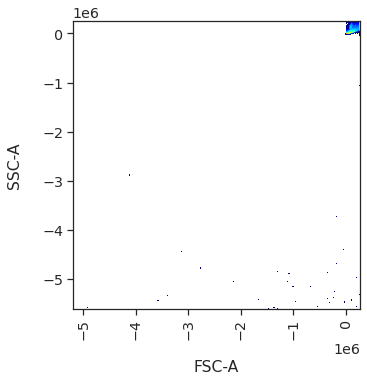

In [12]:
gates.plot_population("root", x="FSC-A", y="SSC-A", transform_x=None, transform_y=None)

There are some outliers in this data that have squeezed all the events into the top right corner. We can use the `create_plot_kwargs` argument to edit the x and y axis limits. For this to take effect `autoscale` must be set to `False`:

<AxesSubplot:xlabel='FSC-A', ylabel='SSC-A'>

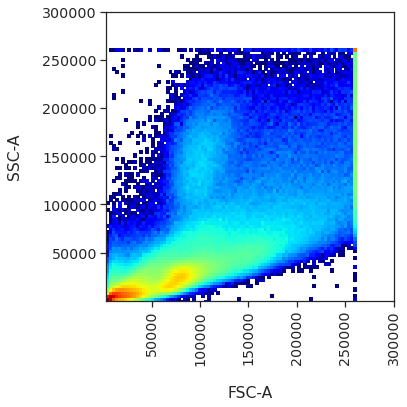

In [13]:
gates.plot_population("root", x="FSC-A", y="SSC-A", transform_x=None, transform_y=None,
                      create_plot_kwargs={"xlim": (0, 300000), "ylim": (0, 300000), "autoscale": False})

<h1>Types of Gates</h1>

Above we can see a lymphocyte population, but amongst a lot of debris and various other leukocyte populations. The objective will be to create a gating strategy that can identify CD3+ lymphocytes from the above, granting a starting point for more complex analysis. The complete gating strategy for this is discussed in a later notebook in this section. For now I'm going to discuss gates and gating algorithms more generally.

The `GatingStrategy` and the `Gate` objects we associated to it allow us to design some autonomous methods for identifying the same population across many biological samples, and the gates will "move" in response to observed inter-sample variation; this is what we mean by "data-driven gating".

Autonomous gates achieve this "data-driven moving" of gates by "fitting" an algorithm to every new instance of data and then identifying the intended population based on it's likeness to the original definition.

The `Gate` is what houses the algorithm applied. There are three types of `Gate`'s each inheriting from the base `Gate` class. These types of gates differ by the geometry they apply to the data to generate populations:

* `ThresholdGate`
* `PolygonGate`
* `EllipseGate`

All of the `Gate` objects act on data using the following methods and order of events:

* `fit` - the newly created `Gate` is 'fitted' to some example data, generating one or more `Child` objects stored within the `Gate` itself; populations of cells e.g. contained within the gate or separated by a threshold
* `label_children` (optional) - apply recognisable names to `Child` populations
* `fit_predict` - the algorithm is applied to new data and the resulting `Child` populations are matched to those originally identified with the first example data (matching depends on the type of `Gate` used)

In practice we don't use the `fit` and `fit_predict` methods directly. Instead, we define a `Gate` and then provide that `Gate` to `preview_gate` method of `GatingStrategy`. This will 'fit' the `Gate` to some data and provide a preview of the results. We then call `label_children` to give the results some meaningful names. Then we call `apply_gate` to apply the `Gate` and generate `Population`'s. When we have new data, we can simply refer to the name of the `Gate` in the `apply_gate` method and generate the same `Population`'s.

As a simple example, I'm going to show you a `ThresholdGate` defined on one sample and then applied on another:

In [14]:
test = ThresholdGate(gate_name="test",
                     parent="root",
                     x="CD3",
                     y="LD",
                     transform_x="logicle",
                     transform_y="logicle",
                     method="density")

We've defined the `ThresholdGate` above. All `Gate`'s require a name, the name of the parent population it acts upon, the x and y axis dimensions it is applied in, and optionally transformations to be applied to the x and/or y-axis prior to applying the gate. The results are independent of the transform applied, since it is the index of population events that are stored as results, not the events themselves.

There are additional arguments that are specific to the `Gate` being used, such as `method` and `method_kwargs`, these will be discussed later.

We now pass this `ThresholdGate` to `preview_gate` and we'll get a plot of our gating results:

<AxesSubplot:xlabel='CD3', ylabel='LD'>

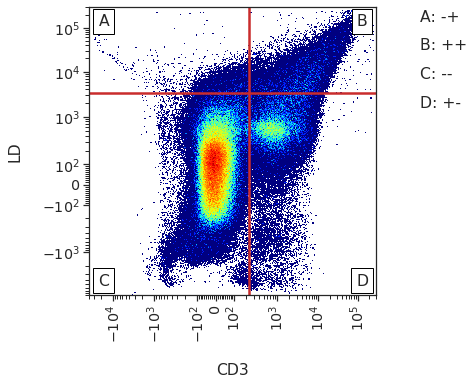

In [15]:
gates.preview_gate(test)

Awesome! The data has been separated based on local density minima. The population "+-" is of most interest, so let's give it a useful name. Any populations that are not labeled in the dictionary passed to `label_children` are ignored by future application of the gate.

In [16]:
test.label_children({"+-": "Live CD3+ cells"})

Currently, `test` has been defined and the child populations labeled, but no `Population`'s have been generated and added to the `FileGroup` currently linked to our `GatingStrategy`. To apply `test` and create the populations, I must call the `apply_gate` method. This will apply the gate but will also associate the gate to the `GatingStategy` so it can be applied to future data (to apply a gate without associating to the `GatingStrategy` set `add_to_strategy` argument in `apply_gate` to `False`)

----- test -----
Parent (root) n: 3143219
...child Live CD3+ cells n: 338595; 10.772236996531264% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

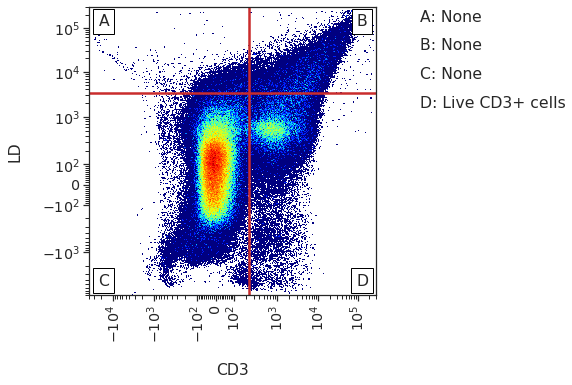

In [17]:
gates.apply_gate(test)

In [18]:
gates.print_population_tree()

root
└── Live CD3+ cells


Now that the `Gate` has been applied and added to the `GatingStrategy` I can associate `gates` to some new data and apply `test`. I don't actually need the `test` object anymore, I can just refer to the gate name, which is "test". Below I load in a new sample, call `apply_gate` and the algorithm is fitted to the new data and the child populations labeled accordingly.

In [19]:
gates.load_data(experiment=exp, sample_id='318-01')

----- test -----
Parent (root) n: 5443927
...child Live CD3+ cells n: 1020533; 18.74626533382979% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

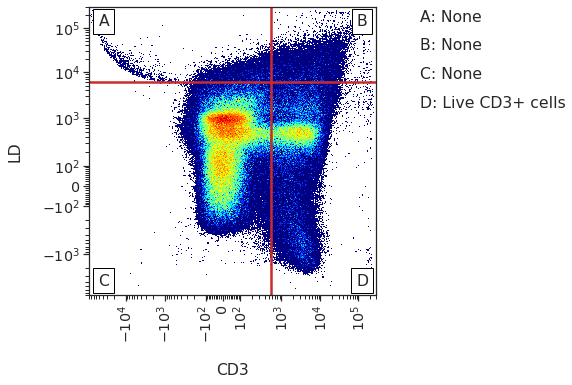

In [27]:
gates.apply_gate(gate="test")

<h2>ThresholdGate</h2>

The ThresholdGate is adapted from the <a href="https://pubmed.ncbi.nlm.nih.gov/25378466/">FlowDensity</a> algorithm and subsets data based on the properties of the estimated probability
density function of the underlying data. For each axis, kernel density estimation
(KDEpy.FFTKDE) is used to estimate the PDF and a straight line "threshold" applied
to the region of minimum density to separate populations.
This is achieved using a peak finding algorithm and a smoothing procedure, until either:

* Two predominant "peaks" are found and the threshold is taken as the local minima
  between there peaks
* A single peak is detected and the threshold is applied as either the quantile
  given in method_kwargs or the inflection point on the descending curve.

Alternatively the "method" can be "manual" for a static gate to be applied; user should
provide x_threshold and y_threshold (if two-dimensional) to "method_kwargs", or "method"
can be "quantile", where the threshold will be drawn at the given quantile, defined by
"q" in "method_kwargs".

Additional kwargs to control behaviour of ThresholdGate when method is "density"
can be given in method_kwargs:

*  kernel (default="guassian") - kernel used for KDE calculation
   (see KDEpy.FFTKDE for available kernels)
* bw (default="silverman") - bandwidth to use for KDE calculation, can either be
  "silverman" or "ISJ" or a float value (see KDEpy)
* min_peak_threshold (default=0.05) - percentage of highest recorded peak below
  which peaks are ignored. E.g. 0.05 would mean any peak less than 5% of the
  highest peak would be ignored.
* peak_boundary (default=0.1) - bounding window around which only the highest peak
  is considered. E.g. 0.1 would mean that peaks are assessed within a window the
  size of peak_boundary * length of probability vector and only highest peak within
  window is kept.
* inflection_point_kwargs - dictionary; see CytoPy.data.gate.find_inflection_point
* smoothed_peak_finding_kwargs - dictionary; see CytoPy.data.gate.smoothed_peak_finding

**How are populations in new data labeled?**

When new data is exposed to a defined `ThresholdGate`, populations are matched based on their relative position compared to the threshold. So if a new population is right of the x-axis threshold but below the y-axis threshold it will share the same label as the population found in the example data right of the x-axis threshold and below the y-axis threshold.

In [20]:
# Since I haven't called 'save' I can reload the project and all previous Populations will 
# be lost, letting me start fresh
peritonitis = Project.objects(project_id="Peritonitis").get()
exp = peritonitis.get_experiment("PBMC T cells")
gates = GatingStrategy(name="T cell gating")
gates.load_data(experiment=exp, sample_id='305-02')

All the `Gate` classes have the option to create static gates that do not move in response to new data. To create a static gate specify the `method` as `manual` and pass threshold values for the x and/or y-axis in the `method_kwargs`:

<AxesSubplot:xlabel='CD3'>

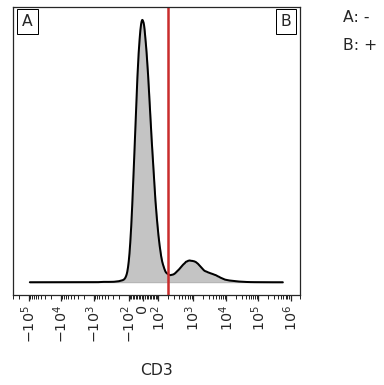

In [21]:
static_1d = ThresholdGate(gate_name="test",
                          parent="root",
                          x="CD3",
                          transform_x="logicle",
                          method="manual",
                          method_kwargs={"x_threshold": 200})
gates.preview_gate(static_1d)

What if you want the preview plot to have a different y-axis to gain a better understanding of the resulting population? Easy, pass transform to `create_plot_kwargs` and the y-axis variable to `plot_gate_kwargs` argument of `preview_gate`. Before calling `preview_gate` I must also call `reset_gate`, since the previous `preview_gate` call will populate `static_1d` with `Child` populations. Calling `preview_gate` again without reseting the gate will raise an error.

<AxesSubplot:xlabel='CD3', ylabel='LD'>

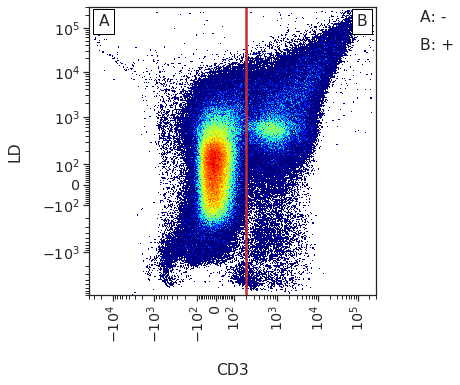

In [22]:
static_1d.reset_gate()
gates.preview_gate(static_1d, 
                   create_plot_kwargs={"transform_y": "logicle"},
                   plot_gate_kwargs={"y": "LD"})

<AxesSubplot:xlabel='CD3', ylabel='LD'>

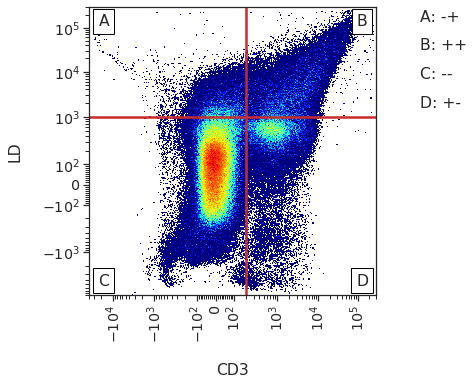

In [23]:
static_2d = ThresholdGate(gate_name="test",
                          parent="root",
                          x="CD3",
                          y="LD",
                          transform_x="logicle",
                          transform_y="logicle",
                          method="manual",
                          method_kwargs={"x_threshold": 200, "y_threshold": 1000})
gates.preview_gate(static_2d)

<AxesSubplot:xlabel='CD3', ylabel='LD'>

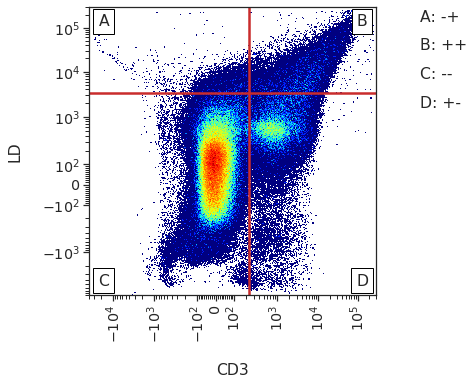

In [24]:
cd3_ld = ThresholdGate(gate_name="CD3+ Live gate",
                       parent="root",
                       x="CD3",
                       y="LD",
                       transform_x="logicle",
                       transform_y="logicle",
                       method="density")
gates.preview_gate(cd3_ld)

----- CD3+ Live gate -----
Parent (root) n: 3143219
...child CD3+ Live cells n: 338595; 10.772236996531264% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

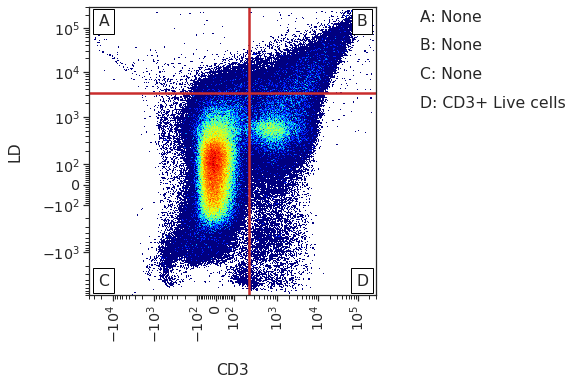

In [25]:
cd3_ld.label_children({"+-": "CD3+ Live cells"})
gates.apply_gate(cd3_ld)

<AxesSubplot:xlabel='Va7-2'>

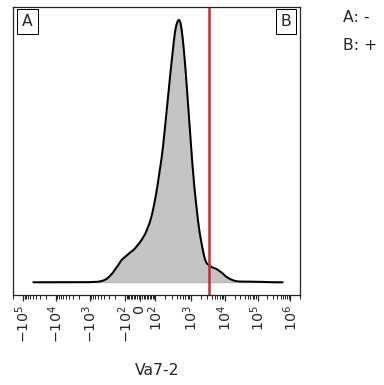

In [26]:
test = ThresholdGate(gate_name="test",
                     parent="CD3+ Live cells",
                     x="Va7-2",
                     transform_x="logicle",
                     method="density")
gates.preview_gate(test)

Above is an example of the density gating algorithm applied to live CD3+ cells in one dimension. There are many parameters that can be adjusted to change the behavior of this algorithm. The steps taken in this algorithm are listed below along with the arguments that can be given in `method_kwargs` to adjust behaviour:

1. The 1 or 2D PDF is estimated using kernel density estimation. Change `kernel` to adjust the distribution used to estimate the density function and change `bw` to control the bandwidth of the chosen kernel. The <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html">python data science handbook</a> and <a href="https://kdepy.readthedocs.io/en/latest/">KDEpy</a> are great resources to learn about KDE's.
2. Apply a <a href="https://github.com/demotu/detecta/blob/master/detecta/detect_peaks.py">peak finding algorithm</a> controlled using two parameters:
    * `min_peak_threshold`: percentage of highest recorded peak below which peaks are ignored. E.g. 0.05 would mean any peak less than 5% of the highest peak would be ignored.
    * `peak_boundary`: bounding window around which only the highest peak is considered. E.g. 0.1 would mean that peaks are assessed within a window the size of peak_boundary * length of probability vector and only highest peak within window is kept.
3. If a single maxima (peak) is found, the threshold is taken as the inflection point between the local maxima and the local minima either to the right or left of the peak. The PDF is smoothed using a Savitzky-Golay filter and the inflection point found to be the point at which the second derivative of the slope is at maximum. Pass a dictionary of keyword arguments to `inflection_point_kwargs` to control this process. See `cytopy.data.gate.find_inflection_point` for full details. An example is `incline` which controls whether the inflection point is chosen on the incline to the peak (left) or the decline away from the peak (right). By default this is `False`.  
4. If only two points are found, the threshold is taken as the local minima between the two peaks
5. If more than two peaks are found, a Savitzky-Golay filter is applied to smooth the PDF with an increasing window size until the number of peaks is 2 or less. The smoothing process can be controlled with a dictionary of keyword arguments passed to `smoothed_peak_finding_kwargs` as a dictionary. See `cytopy.data.gate.smoothed_peak_finding` for details.

In most cases the default settings will be fine, but sometimes you might want to alter them. Later we will discuss hyperparameter search which allows you to define a range of hyperparameters and the optimal parameters are chosen each time the gate is applied to new data.

<AxesSubplot:xlabel='Va7-2'>

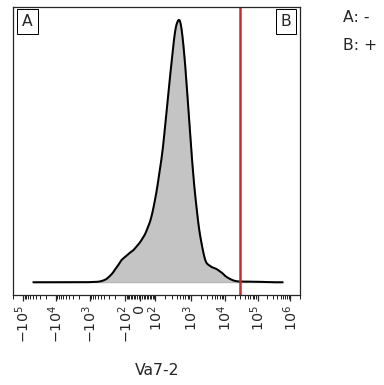

In [27]:
test.reset_gate()
# Setting min_peak_threshold very low will result in more local maxima being accounted for 
# and very small peaks being included in threshold calculation
test.method_kwargs = {"min_peak_threshold": 0.001}
gates.preview_gate(test)

<AxesSubplot:xlabel='Va7-2'>

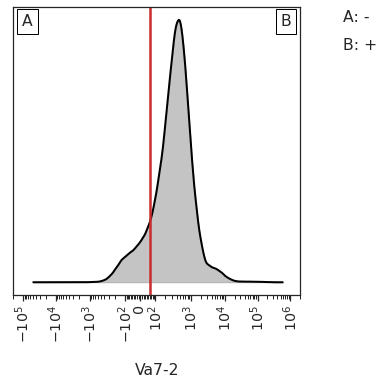

In [28]:
test.reset_gate()
# Find the inflection point on the incline of the peak rather than the decline
test.method_kwargs = {"inflection_point_kwargs": {"incline": True}}
gates.preview_gate(test)

<AxesSubplot:xlabel='Va7-2'>

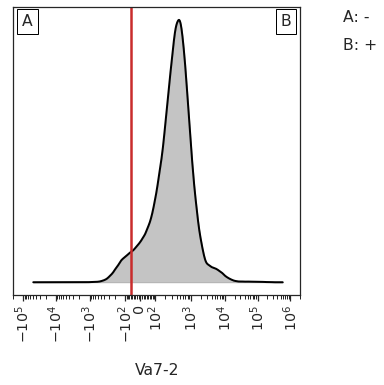

In [29]:
test.reset_gate()
# Find the inflection point on the incline of the peak rather than the decline
test.method_kwargs = {"inflection_point_kwargs": {"incline": True},
                      "bw": 0.1}
gates.preview_gate(test)

<h2>PolygonGate</h2>

The PolygonGate subsets data based on the results of an unsupervised learning algorithm
such a clustering algorithm.The polygon shape(s) that form the "gate(s)" are derived from the convex hull of the resulting cluster(s).

PolygonGate supports any clustering algorithm from the
Scikit-Learn machine learning library. Support is extended to any clustering library
that follows the Scikit-Learn template, but currently this only includes HDBSCAN.
Contributions to extend to other libraries are welcome. The name of the class to use
should be provided in "method" along with keyword arguments for initiating this class
in "method_kwargs".

Alternatively the "method" can be "manual" for a static gate to be applied; user should
provide x_values and y_values (if two-dimensional) to "method_kwargs" as two arrays,
this will be interpreted as the x and y coordinates of the polygon to fit to the data.

**How are populations in new data labeled?**

When a clustering algorithm is applied to some new data this will result in polygon gates derived from the convex hull of identified clusters. To match these polygons to expected populations the hausdorff distance is employed [1], defined as:

$$H(A, B) = \max(h(A, B), h(B, A))$$

where:

$$h(A,B) = \max_{a \in A}\min_{b \in B} \lVert a - b\rVert$$

and $A$ is the set of coordinates defining an expected gate (as defined from the example data) and $B$ is the comparison set of coordinates of a gate generated with new data. CytoPy seeks to assign the name of $A$ to the $B$ with the smallest hausdorff distance.

In the example below, a population of interest is captured by a gate in the example data in sample 1. This is the blue population. In the new data, three populations are identified from a K means clustering algorithm and we want to label and keep the gate most similar to the gate identified in sample 1. The hausdorff distance is shown by the arrows comparing the gate in sample 1 to the three gates in sample 2. The gate with the minimal distance, 2.243, will be chosen.

![](imgs/hausdorff_dist.png)

[1] Daniel P. Huttenlocher, Gregory A. Klanderman, and William J. Rucklidge, Comparing Images Using the Hausdorff Distance. IEEE Transactions on pattern analysis and machine intelligence, 15(9) Sep 1993.

Below I'm going to run through some examples, but be aware that `PolygonGate` supports any clustering algorithm from the Scikit-Learn library (https://scikit-learn.org/stable/modules/clustering.html). Let's try identifying V$\delta$2$^{+}$ $\gamma\delta$ T cells:

<h3>Static polygon gates</h3>

Starting with a static gate, you pass the `method` "manual" and provide x and y coordinates into the `method_kwargs`. This isn't data driven however, so will not respond to new data.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

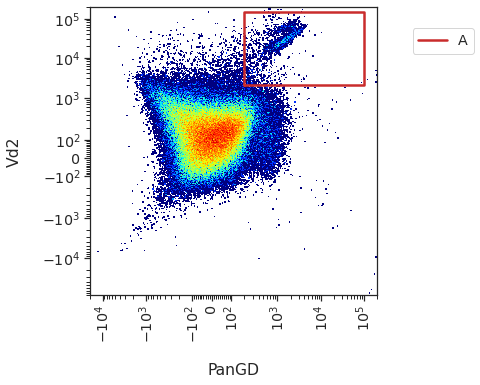

In [30]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   method="manual",
                   method_kwargs={"x_values": [200, 100000, 100000, 200, 200],
                                  "y_values": [2000, 2000, 150000, 150000, 2000]})
gates.preview_gate(test)

<h3>Mini-batch K-Means</h3>

A simple place to start is with <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans">mini-batch K-means</a>. This algorithm is quick but only tends to work well on data with spherical clusters of even size. For all the Scikit-Learn methods employed, you simply name the desired class in `method` and pass any additional arguments you would normally pass when initiating the classifier to `method_kwargs`.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

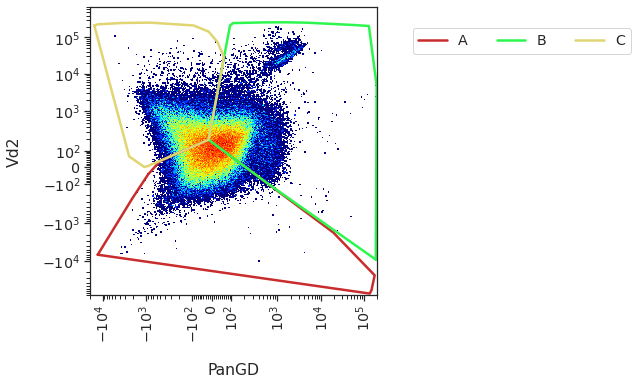

In [31]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   method="MiniBatchKMeans",
                   method_kwargs={"n_clusters": 3, "batch_size": 6000, "n_init": 5})
gates.preview_gate(test)

<h3>Hierarchical clustering with downsampling</h3>

K means didn't quite do the trick. What about <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering">hierarchical clustering</a>?

In [55]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   method="AgglomerativeClustering",
                   method_kwargs={"n_clusters": 4, "linkage": "ward"})
gates.preview_gate(test)

MemoryError: Unable to allocate 427. GiB for an array with shape (57323117715,) and data type float64

We got an error here telling us that there wasn't enough memory to perform this operation. Hierarchical clustering does not scale well in terms of space complexity and this population is pretty big:

In [56]:
gates.filegroup.get_population("CD3+ Live cells").n

338595

Not to worry, we can use the `sampling` argument! CytoPy supports a few different sampling techniques, all implemented in `CytoPy.flow.sampling`. The simplest is "uniform". We provide a dictionary to `sampling` which must contain a value for `method` and then all additional key:value arguments are interpreted as additional arguments to pass to the chosen sampling method.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

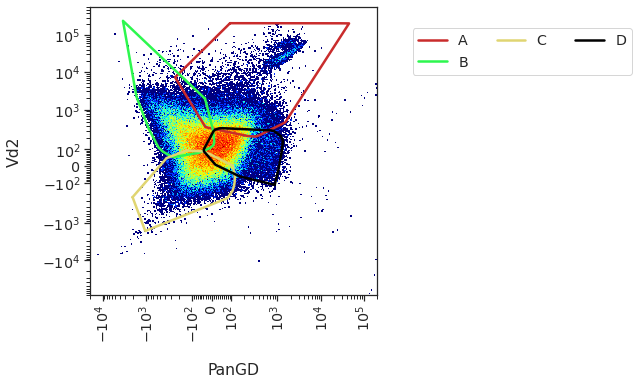

In [33]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   sampling={"method": "uniform", "n": 10000},
                   method="AgglomerativeClustering",
                   method_kwargs={"n_clusters": 4, "linkage": "ward"})
gates.preview_gate(test)

This was better but can still be improved. The issue is that our V$\delta$2+ $\gamma\delta$ T cells are overshadowed by much larger populations. Is there a way we can artificially make them more prominent? This is where we can employ density dependent downsampling. Adapted from <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3196363/">SPADE</a>, density dependent downsampling generates a nearest neighbours graph of a subsample of our events. The graph is used to measure the density of this space. Events with lots of neighbours are assigned a lower weight that events with few neighbours, and these weights are used to control the probability that an event is sampled during the downsample procedure. Therefore rare populations are not under-represented.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

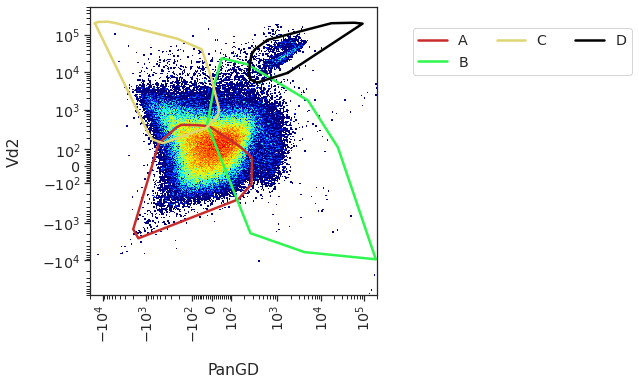

In [34]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   sampling={"method": "density"},
                   method="AgglomerativeClustering",
                   method_kwargs={"n_clusters": 4, "linkage": "ward"})
gates.preview_gate(test)

Much better! The V$\delta$2+ $\gamma\delta$ T cells are better represented in the clustering.

<h3>Birch clustering</h3>
 
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html">Birch clustering</a> is a memory efficient algorithm that works well when the number of dimensions is few and the data contains a large number of subclusters.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

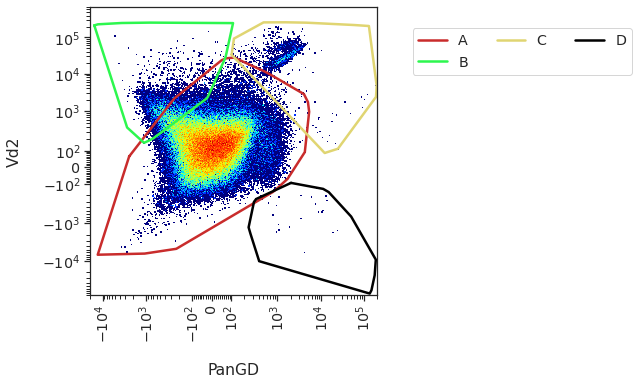

In [35]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   method="Birch",
                   method_kwargs={"threshold": 0.1, "n_clusters": 4})
gates.preview_gate(test)

<h3>HDBSCAN with downsampling</h3>

Although not a part of the Scikit-Learn library, <a href="https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html">HDBSCAN</a> follows the Scikit-Learn signatures and is compatible with CytoPy. I intend to include more libraries like this as the ecosystem grows. HDBSCAN is an extension of the popular DBSCAN algorithm but requires fewer hyperparameters. The user can generally get away with providing one parameter `min_cluster_size`. This algorithm also doesn't require that the user specifies the number of clusters to expect, as this is inferred from the data itself. In most cases downsampling will be required, however.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

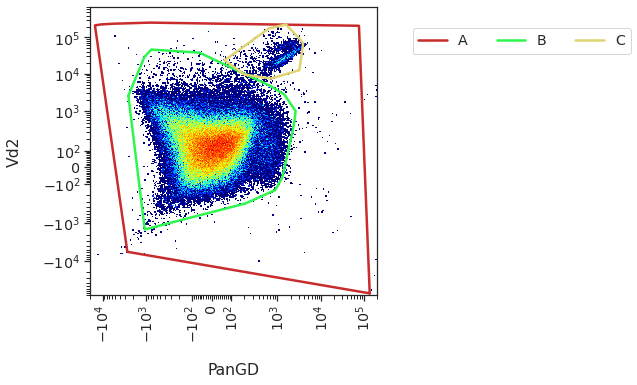

In [36]:
test = PolygonGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   sampling={"method": "uniform", "frac": 0.1},
                   method="HDBSCAN",
                   method_kwargs={"min_cluster_size": 10})
gates.preview_gate(test)

<h2>EllipseGate</h2>

The EllipseGate uses probabilistic mixture models to subset data into "populations". For
each component of the mixture model the covariance matrix is used to generate a confidence
ellipse, surrounding data and emulating a gate. EllipseGate can use any of the methods
from the Scikit-Learn mixture module. Keyword arguments for the initiation of a class
from this module can be given in "method_kwargs". **Note: CytoPy currently only supports use of a gaussin kernel**

**Confidence ellipse?**

Each component of the resulting mixture model will generate a 2x2 covariance matrix, explaining the joint variability of the estimated function (the underlying distribution will be modeled as a mixture of normal distributions). The covariance matrix can be represented as an ellipse, visualising the multivariate normal distribution. The ellipse is centered on the mean of the chosen component and oriented in the direction of the first eigenvector of the covariance matrix. We can approximate the likelihood of a data point falling within the bounds of the ellipse using the chi-squared distribution. This means we can provide the percentile of the chi-squared distribution e.g. 0.95 and generate an ellipse where the length of the primary axis (the longest axis) is such that 95% of data attributed to this component is contained within the ellipse. The user specifies the confidence interval using `conf` in `method_kwargs`, where the default value is `0.95`. This lets the user specify how "tight" they want their gate in a data driven approach.

[1] Jake VanderPlas, Python Data Science Handbook O’Reilly (2017)

**How are populations in new data labeled?**

Polygon gates are generated using the covariance ellipse at the chosen confidence interval. Population matching is then performed the same way as with `PolygonGate`.

Repeating the same task as before, I'm going to try and gate the V$\delta$2 $\gamma\delta$ T cell population. For the GaussianMixture class, I specify the number of components (how many bivariant normals I think are present in the data, one being the desired V$\delta$2 $\gamma\delta$ T cell population). It is also useful to set the random seed. I tend to start with a large number of components to get a sense of the underlying data.

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

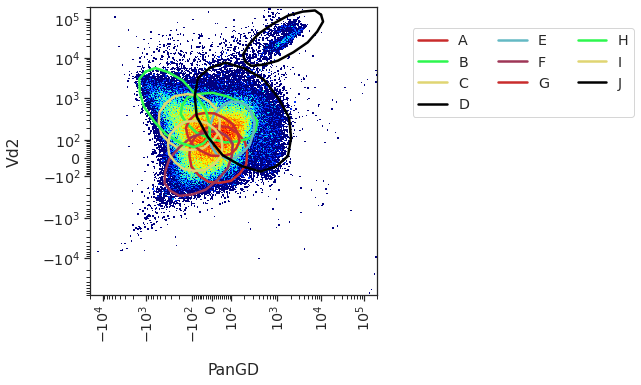

In [37]:
test = EllipseGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   transform_x="logicle",
                   transform_y="logicle",
                   method="GaussianMixture",
                   method_kwargs={"n_components": 10, "random_state": 42})
gates.preview_gate(test)

It looks like the V$\delta$2 $\gamma\delta$ T cell population is being overshadowed by the larger populations below it. I can use density dependent downsampling again to try and increase it's influence:

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

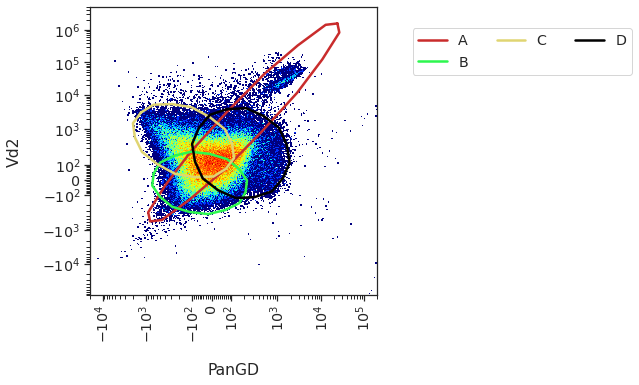

In [38]:
test = EllipseGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   sampling={"method": "density"},
                   transform_x="logicle",
                   transform_y="logicle",
                   method="GaussianMixture",
                   method_kwargs={"n_components": 4, "random_state": 42})
gates.preview_gate(test)

That worked well, let's now increase the width of the gate by choosing a different confidence interval for the covariance ellipse:

<AxesSubplot:xlabel='PanGD', ylabel='Vd2'>

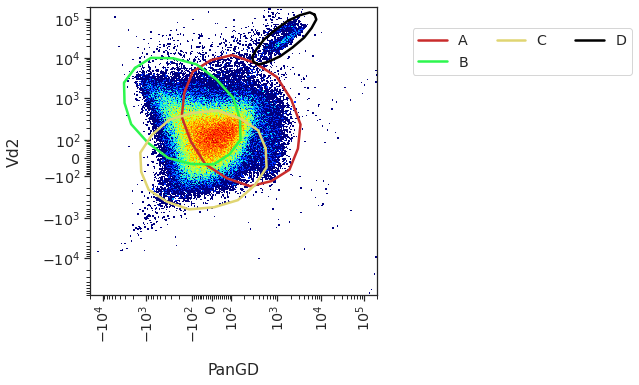

In [39]:
test = EllipseGate(gate_name="test",
                   parent="CD3+ Live cells",
                   x="PanGD",
                   y="Vd2",
                   sampling={"method": "density"},
                   transform_x="logicle",
                   transform_y="logicle",
                   method="GaussianMixture",
                   method_kwargs={"n_components": 4, "random_state": 42, "conf": 0.99})
gates.preview_gate(test)

<h1>Hyperparameter search</h1>

An issue that can arise with autonomous gates is with the choice of hyperparameters: the chosen parameters when defining the gate might be optimal in identifying the desired population in the example data, but this might not hold true for subsequent data. This issue is further exacerbated by the batch effects discussed in the previous chapter.

CytoPy's `GatingStrategy` attempts to overcome this issue by providing the `add_hyperparameter_grid` method. The user specifies a gate by name and provides a parameter "search space" in the form of a dictionary, where each key is a parameter and the values a list of parameter values to search.

When the gate is applied to subsequent data, all possible combinations (exhaustive search) of parameter values are considered and the results generate a set of possible gates. The gate that most resembles the originally defined gate (either in properties of the gate itself or the underlying population that it captures) is chosen amongst the set of possibilities generated within the parameter search space.

When defining the search space with `add_hyperparameter_grid`, the user can also specify the `cost` function used to search for the optimal match. The cost function will depend on the type of gate:

* ThresholdGate:
    - "manhattan" (default): optimal parameters are those that result in the population whom's signature (the mean vector of all channels for that population) is of minimal distance to the original data used to define the gate. The manhattan distance is used as the distance metric.
    - "euclidean": optimal parameters are those that result in the population whom's signature (the mean vector of all channels for that population) is of minimal distance to the original data used to define the gate. The euclidean distance is used as the distance metric.
    - "threshold_dist": optimal parameters are those that result in the threshold
       whom's distance to the original threshold defined are smallest
* PolygonGate & EllipseGate:
    - "hausdorff" (default): parameters chosen that minimise the hausdorff distance
      between the polygon generated from new data and the original polygon gate created
      when the gate was defined
    - "manhattan": optimal parameters are those that result in the population whom's signature
      is of minimal distance to the original data used to define the gate. The manhattan distance is used
      as the distance metric.
    - "euclidean": optimal parameters are those that result in the population whom's signature
      is of minimal distance to the original data used to define the gate. The euclidean distance is used
      as the distance metric.
      
Let's check out some examples:

In [11]:
# Since I haven't called 'save' I can reload the project and all previous Populations will 
# be lost, letting me start fresh
peritonitis = Project.objects(project_id="Peritonitis").get()
exp = peritonitis.get_experiment("PBMC T cells")
gates = GatingStrategy(name="T cell gating")
gates.load_data(experiment=exp, sample_id='305-02')

Start by defining a gate that identified live CD3+ cells

<AxesSubplot:xlabel='CD3', ylabel='LD'>

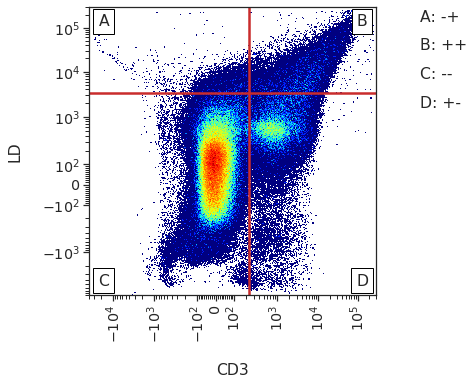

In [12]:
cd3ld = ThresholdGate(gate_name="CD3 Live/Dead Gate",
                     parent="root",
                     x="CD3",
                     y="LD",
                     transform_x="logicle",
                     transform_y="logicle",
                     method="density")
gates.preview_gate(cd3ld)

----- CD3 Live/Dead Gate -----
Parent (root) n: 3143219
...child CD3+ Live cells n: 338595; 10.772236996531264% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

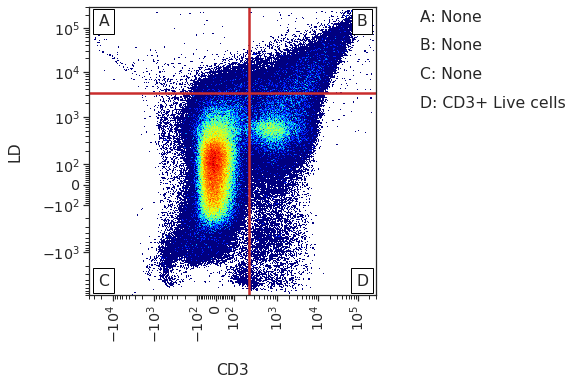

In [13]:
cd3ld.label_children({"+-": "CD3+ Live cells"})
gates.apply_gate(cd3ld)

Load some new data and apply the gate:

----- CD3 Live/Dead Gate -----
Parent (root) n: 8884224
...child CD3+ Live cells n: 191886; 2.159850989799447% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

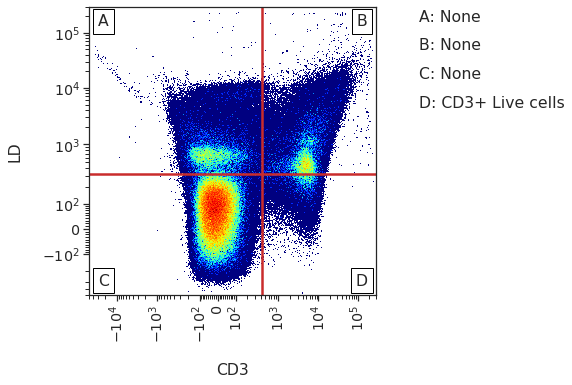

In [14]:
gates.load_data(experiment=exp, sample_id='175-09')
gates.apply_gate("CD3 Live/Dead Gate")

Above you can see that in this new data the gate is giving us poor performance because the population has shifted in the Live/Dead channel. Let's define a parameter search space and add this to the `GatingStrategy`:

In [15]:
params = {"min_peak_threshold": [0.2, 0.1, 0.05, 0.01],
          "peak_boundary": [0.5, 0.25, 0.1],
          "bw": ["silverman", 0.1]}
gates.add_hyperparameter_grid(gate_name="CD3 Live/Dead Gate", 
                              params=params)

Since the gate has been applied to sample 175-09_PT, the target population "CD3+ Live cells" exists, so reapplying the gate will raise an error. Let's first delete the population:

In [16]:
gates.delete_populations(["CD3+ Live cells"])

Reapply the gate with hyperparameter search:

----- Hyperparameter optimisation: CD3 Live/Dead Gate -----
Grid space: 24
Fitting gates across parameter grid...


  0%|          | 0/24 [00:00<?, ?it/s]

Matching optimal populations...
------------------ complete ------------------
----- CD3 Live/Dead Gate -----
Parent (root) n: 8884224
...child CD3+ Live cells n: 966541; 10.879295704385662% of parent
------------------------


<AxesSubplot:xlabel='CD3', ylabel='LD'>

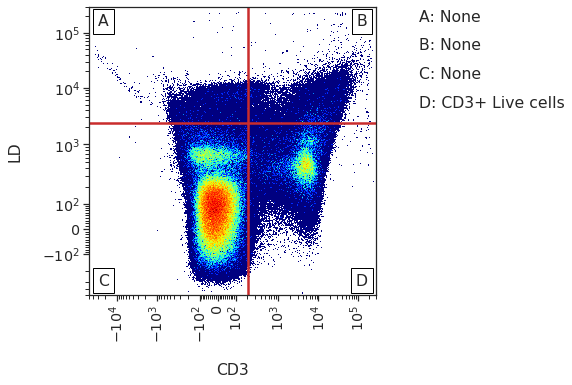

In [17]:
gates.apply_gate("CD3 Live/Dead Gate")

We see that the performance of this gate has been greatly improved compared to without hyperparameter search. 

<h1>Handling batch-effects with landmark registration</h1>

Hyperparameter search, as described above, is one way of overcoming the variability between biological specimens that can hinder autonomous methods of gating. If there are significant batch effects however, even adjustment of hyperparameters might not be enough to generate reliable autonomous gates.

CytoPy provides another option when creating a `Gate` in the form of `fda_norm`. This builds on the work of Hahne et al [1] who demonstrated per-channel batch correction using techniques from the field of functional data analysis. In brief, prominent features (such as local maxima or 'peaks') of the probability density function of a channel are aligned between biological specimens using landmark registration. Finak et al [2] went on to demonstrate that this method, although capable of eliminating broad batch effects observable in single channels, they did not alleviate the issue for specific cell subsets. They therefore employed the same methodology but employed during gating, improving the performance of this technique.

When defining a `Gate` we can tell CytoPy to do the same thing. We simply set `fda_norm` to `True` and point to a `FileGroup` for `reference`. By doing so, each time that this `Gate` has it's `fit_predict` method called (fitting to some new data to predict `Population`(s)), the reference sample is loaded into memory and the following performed:

1. PDF estimated for reference and new data using a fast convolution based KDE and bandwidth estimated using the silverman method [3]
2. Landmarks (peaks) are identified using a peak finding algorithm for each data, producing two arrays of landmarks; minimum peak height is by default 0.1% of the local maxima - `fda_norm_kwargs` can be provided a dictionary of keyword arguments to further control this peak finding algorithm
3. The smallest landmark array (i.e. that data with the fewest peaks) is iterated over and each landmark matched to the nearest landmark (absolute distance on the grid space) in the opposing landmark array. This results in two landmark arrays of equal lengths.
4. Landmarks are used to align curves using _landmark registration_ [4]. See below example:

![](imgs/landmark_reg.png)

In the above example the displacement in CD4 is corrected by finding a warping function that defined between the chosen landmarks using monotone cubic interpolation.

[1] Hahne F, Khodabakhshi AH, Bashashati A, Wong CJ, Gascoyne RD, Weng AP, Seyfert-Margolis V, Bourcier K, Asare A, Lumley T, Gentleman R, Brinkman RR. Per-channel basis normalization methods for flow cytometry data. Cytometry A. 2010 Feb;77(2):121-31. doi: 10.1002/cyto.a.20823. PMID: 19899135; PMCID: PMC3648208.

[2] Finak G, Jiang W, Krouse K, Wei C, Sanz I, Phippard D, Asare A, De Rosa SC, Self S, Gottardo R. High-throughput flow cytometry data normalization for clinical trials. Cytometry A. 2014 Mar;85(3):277-86. doi: 10.1002/cyto.a.22433. Epub 2013 Dec 31. PMID: 24382714; PMCID: PMC3992339.

[3] Silverman, B. W. 1992. Density Estimation for Statistics and Data Analysis. London: Chapman & Hall. ISBN 9780412246203

In [79]:
from cytopy.flow.fda_norm import LandmarkReg
import matplotlib.pyplot as plt

Landmark registration is handled in the `fda_norm` module and is facilitated through the `LandmarkReg` class. In practice we don't actually touch this class and handle this through the `GatingStrategy`. To tell a `GatingStrategy` to use normalisation, just use the `add_normalisation` method, specify the gate where normalisation should be performed and a reference sample to adjust data too. If a reference sample is not provided the `FileGroup` currently associated to the `GatingStrategy` will be used:

```
# Use current FileGroup as reference
gates.add_normalisation("CD3+ Live Gate")

# Use different FileGroup as reference
ref = exp.get_sample("175-02_PT")
gates.add_normalisation("CD3+ Live Gate", reference=ref)
```

<h1>Using control data to influence Gates</h1>

A strength of of CytoPy compared to it's predecessors in `R` is the ease at which control data (a common aspect of modern flow cytometry) can be associated to the primary staining results. CytoPy assumes that when a user associates a control to the `FileGroup` of a biological specimen, this represents a staining control such as an FMO or isotype control, collected at the same time as the primary staining.

The control data is stored alongside the primary staining data. When we create `Population`'s, CytoPy keeps track of the index of events in the primary staining data that belong to said population. The populations identified in the primary staining is then used to estimate the same population in the controls. Let's look at our "CD3+ Live cells" as an example: 

In [18]:
gates.load_data(experiment=exp, sample_id='305-02')

In [19]:
gates.print_population_tree()

root
└── CD3+ Live cells


We can see what controls belong to the `FileGroup` attached to `gate`:

In [20]:
gates.filegroup.controls

['CXCR3', 'CD45RA', 'CCR7']

and we can get the `Population` object like so:

In [21]:
gates.filegroup.get_population("CD3+ Live cells")

<Population: Population object>

In [22]:
pop = gates.filegroup.get_population("CD3+ Live cells")

The index for events in the primary data is stored in the `index` attribute:

In [23]:
pop.index

array([     27,      31,      37, ..., 3143159, 3143188, 3143211])

This index is used when we access a `Population`. For example, let's plot CXCR3 for live CD3+ cells:

<AxesSubplot:xlabel='CXCR3', ylabel='CD3'>

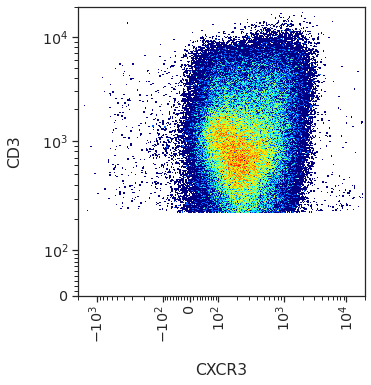

In [24]:
gates.plot_population("CD3+ Live cells", "CXCR3", "CD3", transform_x="logicle", transform_y="logicle")

CytoPy assumes that the control data is collected on the same biological specimen and at the same time as the primary staining. Therefore batch effects should be minimal and the classification of the desired cell population in the primary staining should serve as great training data for predicting the same population in our control samples.

When we try to access the population for a control, CytoPy checks if the population index exists. If it does exist, the population data in the primary staining is used to train a classifier that predicts the same population in our control data. We can provide the name of any valid Scikit-Learn classifier (or XGBoost) to predict the population for our control.

We can attempt to load the "CD3+ Live cells" population from our control by using the `load_ctrl_population_df` method. I'm setting `transform` to `False`, since I want my plotting functions to transform the data.

In [25]:
ctrl = gates.filegroup.load_ctrl_population_df(ctrl="CXCR3",
                                               population="CD3+ Live cells",
                                               transform=None,
                                               classifier="XGBClassifier")

====== Estimating CD3+ Live cells for CXCR3 control ======
Loading data...
Evaluating classifier with permutation testing...
...Performance (without permutations): 0.9999
...Performance (average across permutations; standard dev): 0.499; 0.0042
...p-value (comparison of original score to permuations): 0.0385
Predicting population for control data...
CD3+ Live cells: 0.108% of root in primary data
Predicted in ctrl: 0.081% of root in control data


By default CytoPy performs permutation testing with cross validation and prints a scoring metric of how well our classifier performs on predicting events in holdout data from the original population acquired from the primary staining. By default the metric used is balanced accuracy, but this can be altered by passing a different metric to `scoring` arguments of `load_ctrl_population_df`. We can also specify additional arguments for our classifier by passing a dictionary to `classifier_params`.

The performance without permutations is normal cross-validation score (default K-folds with 5 rounds) whereas the permutation score is the performance after permutation of the input data. The p-value corresponds to the likelihood that the observed difference before and after permutation occured by chance. We see that the p-value is less than 0.05 and a similar percentage of events are identified in the control as in the primary staining.

We now have a DataFrame of events predicted for our control. Let's use the `plotting` module to plot our control population:

<AxesSubplot:xlabel='CXCR3', ylabel='CD3'>

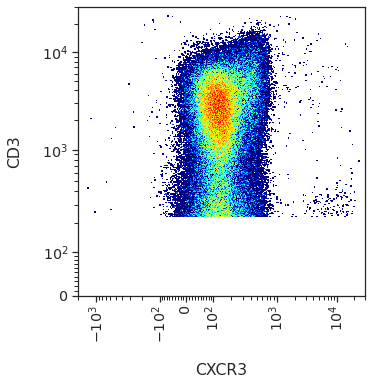

In [28]:
from cytopy.flow.plotting import FlowPlot
plot = FlowPlot(transform_x="logicle", transform_y="logicle")
plot.plot(ctrl, x="CXCR3", y="CD3")

This is a "Full-minus-one" control that is missing CXCR3, which means the population is shifted in the control data compared to primary staining, revealing the "positive" population in our primary stain. We can make this clearer by plotting the control and primary stain side-by-side. Let's load the primary population with the `load_population_df` method:

In [29]:
primary = gates.filegroup.load_population_df(population="CD3+ Live cells", transform=None)

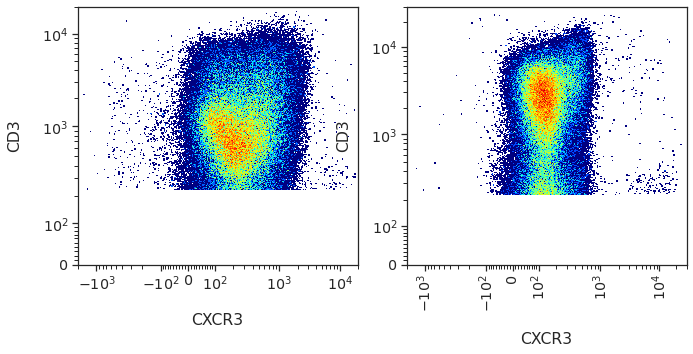

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

primary_plot = FlowPlot(transform_x="logicle", transform_y="logicle", ax=axes[0])
primary_plot.plot(primary, x="CXCR3", y="CD3")

ctrl_plot = FlowPlot(transform_x="logicle", transform_y="logicle", ax=axes[1])
ctrl_plot.plot(ctrl, x="CXCR3", y="CD3")
plt.show()

On the left we have the primary staining and on the right we have the control. We can go one step further and use the `backgate` method of `CreatePlot` to overlay the control data on our primary staining:

<AxesSubplot:xlabel='CXCR3', ylabel='CD3'>

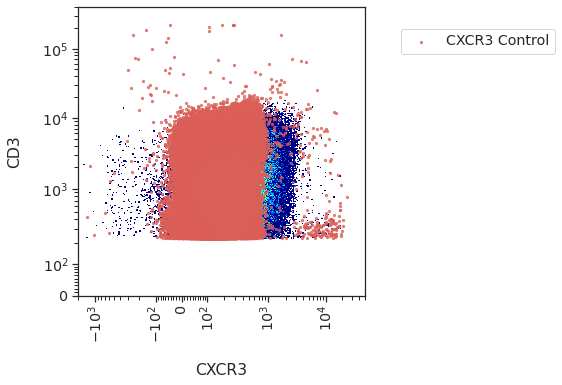

In [32]:
overlay_plot = FlowPlot(transform_x="logicle", transform_y="logicle")
overlay_plot.backgate(parent=primary,
                      children={"CXCR3 Control": ctrl},
                      x="CXCR3",
                      y="CD3",
                      colours="hls")

This `backgate` function can also be used to check the classification of "CD3+ Live cells" in our controls. By setting the `method` to "polygon" I can tell CytoPy to calculate the convex hull of the estimated population and plot it over our root control population (the root population doesn't need estimating in the control, since its simply all the events captured in the control data):

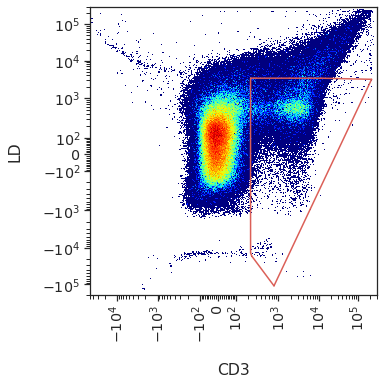

In [35]:
overlay_plot = FlowPlot(transform_x="logicle", transform_y="logicle")
root_ctrl = gates.filegroup.data(source="CXCR3")
ax = overlay_plot.backgate(parent=root_ctrl,
                          children={"CD3+ Live cells": ctrl},
                          x="CD3",
                          y="LD",
                          colours="hls",
                          method="polygon",
                          shade=False)
ax.legend().remove()

Above we have seen how control populations are estimated and stored in CytoPy, how we can plot the control populations, and we've compared the CXCR3 control to our primary data. But how do we use this CXCR3 control to extract CXCR3+ cells with gating?

The `ThresholdGate` supports the use of control data. When defining a `ThresholdGate` the user simply provides the argument `ctrl` with the name of the control to use. When that gate is applied to data in a `GatingStrategy` it will search for the control and the threshold searching algorithm is applied to the control data parent population rather than the primary data parent population. The resulting threshold is then lifted from the control data and applied to the primary data, resulting in new populations. This generates populations that are driven by the control data rather than the primary data. Note: if the parent population is missing for the control data, it will be estimated as shown above. The same goes for any populations upstream of the parent. If gate is applied to data where the control is missing, it will raise an error.

Let's see this applied to the example above. In the first gate I won't specify a value for `ctrl` and the gate will be applied to the primary staining data. Then in the second gate, I will make `ctrl` equal to "CXCR3". This will tell CytoPy to calculate the threshold on the control data and then apply that threshold to the primary data.

<AxesSubplot:xlabel='CXCR3', ylabel='CD3'>

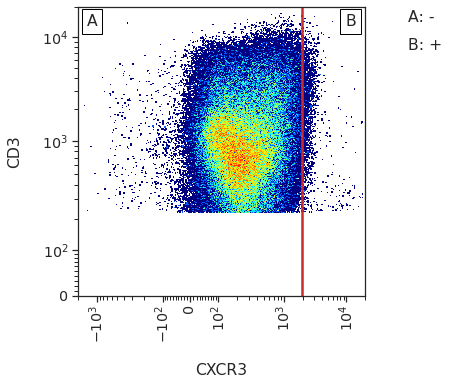

In [38]:
cxcr3_gate = ThresholdGate(gate_name="CXCR3 Gate",
                          parent="CD3+ Live cells",
                          x="CXCR3",
                          transform_x="logicle",
                          method="density",
                          method_kwargs={"min_peak_threshold": 0.5})
gates.preview_gate(cxcr3_gate,
                   create_plot_kwargs={"transform_y": "logicle"},
                   plot_gate_kwargs={"y": "CD3"})

====== Estimating CD3+ Live cells for CXCR3 control ======
Loading data...
Evaluating classifier with permutation testing...
...Performance (without permutations): 0.9996
...Performance (average across permutations; standard dev): 0.4993; 0.006
...p-value (comparison of original score to permuations): 0.0385
Predicting population for control data...
CD3+ Live cells: 0.108% of root in primary data
Predicted in ctrl: 0.081% of root in control data


<AxesSubplot:xlabel='CXCR3', ylabel='CD3'>

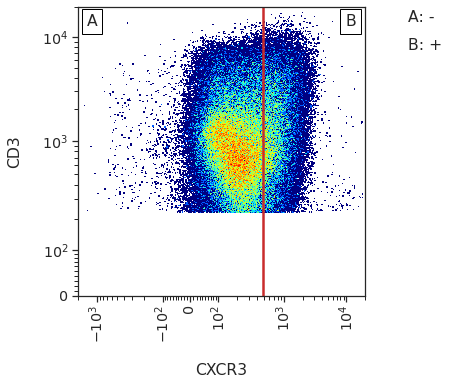

In [40]:
cxcr3_gate = ThresholdGate(gate_name="CXCR3 Gate",
                          parent="CD3+ Live cells",
                          x="CXCR3",
                          transform_x="logicle",
                          method="density",
                          method_kwargs={"min_peak_threshold": 0.5},
                          ctrl_x="CXCR3")
gates.preview_gate(cxcr3_gate,
                   create_plot_kwargs={"transform_y": "logicle"},
                   plot_gate_kwargs={"y": "CD3"})

We see that in the second gate the threshold is shifted as it is calculated on the control data where CXCR3 positive cells are absent.

<h1>Editing Gates, boolean gates, and saving results</h1>

Above I've demonstrated the main feature of the `GatingStrategy` - facilitating autonomous gating - but there a few other things that need to be covered. Notably:

* How to save gates and gating results
* How to edit gates and resulting populations
* Applying `BooleanGate` to merge or subtract populations in a `GatingStrategy`
* Deleting `Gate`'s and/or the `GatingStrategy`

<h2>Saving results</h2>

Our `GatingStrategy` currently contains one `Gate` and is linked to the `FileGroup` "305-02_PT".

In [41]:
gates.gates

[<ThresholdGate: ThresholdGate object>]

In [42]:
gates.filegroup.primary_id

'305-02'

`GatingStrategy` is a MongoDB document, as are the `Gate`(s) that are linked to it. We therefore save our `GatingStrategy` just like we save any document, by calling the `save` method. When we do so we specify two arguments (which both have a default value of `True`): 

* `save_stategy` - saves the `GatingStrategy` and also calls `save` on all associated `Gate`(s)
* `save_filegroup` - calls `save` on the associated `FileGroup` committing all the `Population`(s) that have been generated to the database.

We can think of the `GatingStrategy` as a special collection of `Gate`(s) that tracks the order in which they should be applied (which is the order in which they were first defined) as well as any hyperparameter search space for each `Gate` and any `Action`'s (more on that soon).

In [47]:
gates.save(save_filegroup=True, save_strategy=True)

With the `GatingStrategy` saved I can fetch it from the database like so:

In [48]:
gates = GatingStrategy.objects(name="T cell gating").get()

In [49]:
gates

<GatingStrategy: GatingStrategy object>

In [50]:
gates.gates

[<ThresholdGate: ThresholdGate object>]

If I load the `FileGroup` '305-02' we should see that the populations have been saved:

In [51]:
gates.load_data(experiment=exp, sample_id='305-02')

In [52]:
gates.print_population_tree()

root
└── CD3+ Live cells


This `GatingStrategy` can then be applied to new data and when we call `save`, the `Population`(s) generated from the applied `Gate`(s) will be saved. We can even call the convenience function `apply_all` to apply the entire `GatingStrategy` and all associated `Gate`(s) at once:

In [53]:
gates.load_data(experiment=exp, sample_id="165-09")
gates.apply_all(verbose=True)
gates.save()

------ Applying CD3 Live/Dead Gate ------
----- CD3 Live/Dead Gate -----
Parent (root) n: 219140
...child CD3+ Live cells n: 40829; 18.631468467646254% of parent
------------------------
----------------------------------------


In [54]:
exp.get_sample("165-09").print_population_tree()

root
└── CD3+ Live cells


<h2>Editing gates</h2>

Autonomous gates are not perfect and there might be situations where we want to edit a gate or the results of a gate. To edit a gate is simple, we can act on the `Gate` object and when we call `save` on the `GatingStrategy` the `Gate` will be updated:

In [55]:
cd3ld_gate = gates.get_gate("CD3 Live/Dead Gate")
cd3ld_gate.method_kwargs = {"min_peak_threshold": 0.05}
gates.save()

In [25]:
gates = GatingStrategy.objects(name="T cell gating").get()
gates.get_gate("CD3 Live/Dead Gate").method_kwargs

{'min_peak_threshold': 0.05}

Editing gating results and the subsequent `Population`'s is achieved through the `edit_gate` method. You specify the name of the `Gate` and then provide one or more of the following depending on the type of `Gate`. For threshold gates, provide the `x_threshold` and/or `y_threshold` argument to overwrite the threshold(s) applied by the `Gate`. For a `PolygonGate` or `EllipseGate`, provide a dictionary of populations and updated x, y coordinates.

**Important note**: when you edit a gate, downstream populations will be adjusted but any gates applied to those downstream populations will be static i.e. algorithms are not rerun on the downstream populations, this must be performed manually.

<AxesSubplot:xlabel='CD3', ylabel='LD'>

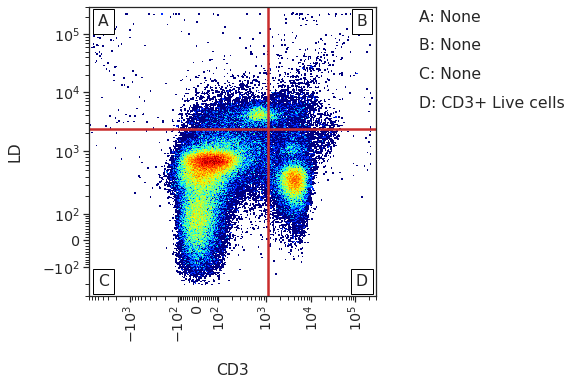

In [26]:
gates.load_data(experiment=exp, sample_id="165-09")
gates.plot_gate("CD3 Live/Dead Gate")

<AxesSubplot:xlabel='CD3', ylabel='LD'>

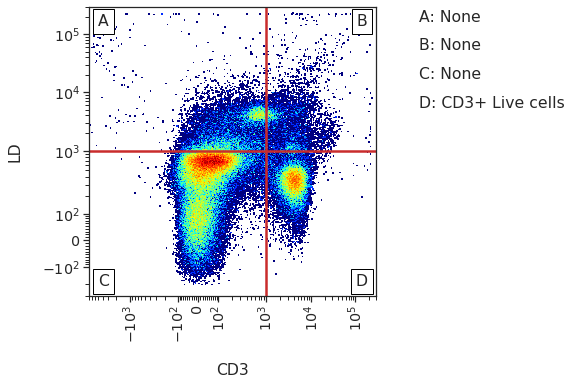

In [27]:
gates.edit_gate("CD3 Live/Dead Gate", x_threshold=1000, y_threshold=1000)
gates.plot_gate("CD3 Live/Dead Gate")

<h2>Boolean gates</h2>

`BooleanGate`'s are a special tool for either merging populations together or subtracting one population from another (i.e. masking). An `BooleanGate` should be added to a `GatingStrategy` in the order in which you wish for it to be applied. So for example, if you have three gates, A, B, and C, and you want the results of B and C to be merged together, the `BooleanGate` should be defined **after** you have defined B and C.

Subtractions also require that the populations share the same parent or that the 'right' population is downstream from the 'left' population.

Let's add a new `Gate` and then a `BooleanGate` to first merge two populations:

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

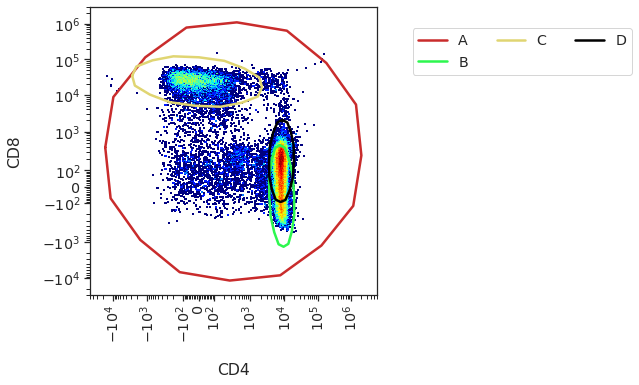

In [28]:
cd4cd8 = EllipseGate(gate_name="CD4CD8",
                     parent="CD3+ Live cells",
                     x="CD4",
                     y="CD8",
                     transform_x="logicle",
                     transform_y="logicle",
                     method="GaussianMixture",
                     method_kwargs={"n_components": 4,
                                    "random_state": 42, 
                                    "conf": 0.999})
gates.preview_gate(cd4cd8)

In [29]:
cd4cd8.label_children({"D": "CD4_1", "B": "CD4_2", "C": "CD8"})

----- CD4CD8 -----
Parent (CD3+ Live cells) n: 37546
...child CD4_2 n: 25783; 68.67043093804934% of parent
...child CD8 n: 6432; 17.130985990518298% of parent
...child CD4_1 n: 23580; 62.802961700314285% of parent
------------------------


<AxesSubplot:xlabel='CD4', ylabel='CD8'>

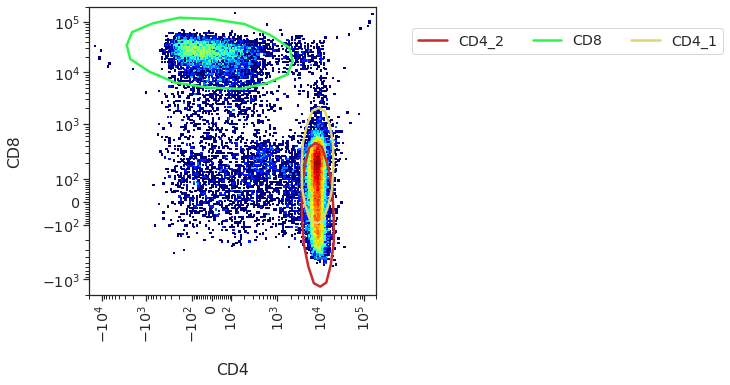

In [30]:
gates.apply_gate(cd4cd8)

The `BooleanGate` inherits from the `PolygonGate` and therefore generates polygon geometries. It takes as arguments `method` and a dictionary as `method_kwargs`. The `method` is a string and should be one of: "AND", "OR" or "NOT":

* AND - generates a new population containing only events present in every population of a given set of populations (provided as a list in method_kwargs with key 'populations')
* OR - generates a new population that is a merger of all unique events from all populations in a given set of populations (provided as a list in method_kwargs with key 'populations')
* NOT - generates a new population that contains all events in some target population that are not present in some set of other populations (requires that user specifies 'target' in method kwargs and a list of populations for comparison with key 'populations')

Apart from this, the `BooleanGate` works like any other gate we've seen in this notebook.

In [31]:
from cytopy.data.gate import BooleanGate
merge_cd4 = BooleanGate(gate_name="Merge CD4", 
                        parent="CD3+ Live cells",
                        x="CD4",
                        y="CD8",
                        transform_x="logicle",
                        transform_y="logicle",
                        method="OR",
                        populations=["CD4_1", "CD4_2"])

<AxesSubplot:xlabel='CD4', ylabel='CD8'>

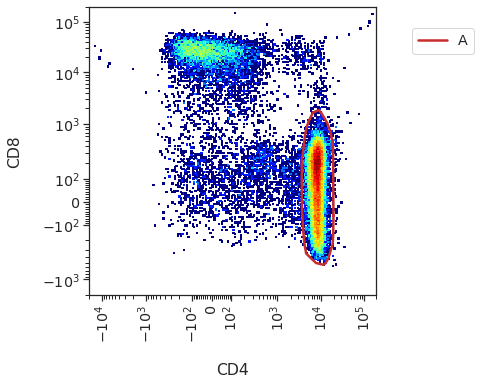

In [32]:
gates.preview_gate(merge_cd4)

In [33]:
merge_cd4.label_children({"A": "CD4 T cells"})

----- Merge CD4 -----
Parent (CD3+ Live cells) n: 37546
...child CD4 T cells n: 27728; 73.85074308847813% of parent
------------------------


<AxesSubplot:xlabel='CD4', ylabel='CD8'>

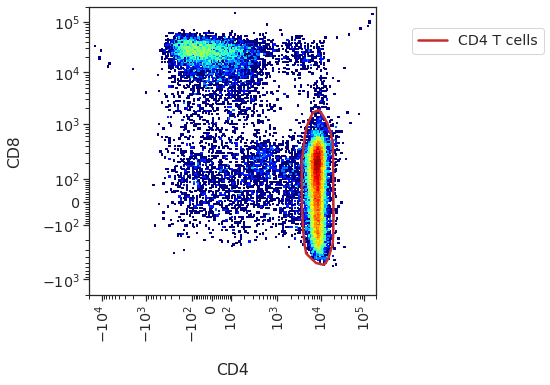

In [34]:
gates.apply_gate(merge_cd4)

In [35]:
gates.print_population_tree()

root
└── CD3+ Live cells
    ├── CD4_2
    ├── CD8
    ├── CD4_1
    └── CD4 T cells


<h2>Deleting gates, populations and gating strategies</h2>

To remove a `Gate` from our gating strategy, we simply use the `delete_gate` method:

In [36]:
gates.delete_gate("CD4CD8")

It should be noted that this does not delete the populations these objects produce:

In [37]:
gates.print_population_tree()

root
└── CD3+ Live cells
    ├── CD4_2
    ├── CD8
    ├── CD4_1
    └── CD4 T cells


Use `delete_populations` to remove them:

In [39]:
gates.delete_populations(["CD4_1", "CD4_2", "CD8", "CD4 T cells"])

When we call `save`, the `GatingStrategy` will be updated as well as the populations in the associated `FileGroup`

In [40]:
gates.save()

If we delete a `GatingStrategy`, we can control whether this deletes `Gate`(s) permanently from the database (remember `Gate`(s) are documents in their own right, they can be reused for other `GatingStrategy`'s) and remove all populations generated by this `GatingStrategy` using the `delete_gates` and `remove_associations` arguments of `delete`. By default both of these arguments are `True`.

In [ ]:
gates.delete(delete_gates=True, remove_associations=True)

Since this is the only `GatingStrategy` there should be no `Gates`:

In [44]:
from cytopy.data.gate import Gate
Gate.objects()

[]

And populations should be removed from '305-02'

In [50]:
# Remember we have to reload the Project since state has changed
peritonitis = Project.objects(project_id="Peritonitis").get()
exp = peritonitis.get_experiment("PBMC T cells")
exp.get_sample("305-02").print_population_tree()

root
